### Get and save embeddings from pretrained NSynth autoencoder model

This is draft notebook showing how to get and save embeddings from pretrained autoencoder

In [2]:
import os
import sys
import numpy as np
from glob import glob
import librosa
import tensorflow as tf
from magenta.models.nsynth.wavenet.h512_bo16 import Config
from tensorflow.python.client import device_lib

import nsynth_utils

/home/julia/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/julia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
# source_path = '/home/julia/DeepVoice_project/LibriSpeech_small/train-clean-100/'
source_path = '/home/julia/DeepVoice_data/samples/'
save_path = '/home/julia/DeepVoice_project/saved_data/samples/'
checkpoint_path = "/home/julia/magenta-demos/jupyter-notebooks/wavenet-ckpt/model.ckpt-200000"

sample_length = 40000
batch_size = 2

# sample_rate = 40000 -> 470 files : len(file) < sample_length
# sample_rate = 64000 -> 2040 files : len(file) < sample_length

In [92]:
# wavfiles = sorted(glob('{}/**/*.wav'.format(source_path), recursive=True))  
wavfiles = ['/home/julia/DeepVoice_data/samples/tone_440-200.wav']

# Iterate through  batches of files
for start_file in range(0, len(wavfiles), batch_size):
    print(start_file)
    batch_number = (start_file / batch_size) + 1
    end_file = start_file + batch_size
    wavfiles_batch = wavfiles[start_file:end_file]

    # Ensure that batch of files has batch_size elements
    # Add elements to batch if needed
    batch_filter = batch_size - len(wavfiles)
    wavfiles_batch.extend(batch_filter * [wavfiles_batch[-1]])
    
    wav_data = np.array([nsynth_utils.load_audio(f, sample_length) for f in wavfiles_batch])

    
  # Load up the model for encoding and find the encoding of "wav_data"
    encoding = nsynth_utils.encode(wav_data, checkpoint_path, sample_length = sample_length)
#     encoding = np.random.rand(batch_size, 16, 175)
    if encoding.ndim == 2:
        encoding = np.expand_dims(encoding, 0)
    for num, (wavfile, enc) in enumerate(zip(wavfiles_batch, encoding)):
        filename = "{}_embeddings.npy".format(wavfile.split("/")[-1].strip(".wav"))
        np.save(save_path + filename, enc)

        if num + batch_filter + 1 == batch_size:
            break

0
INFO:tensorflow:Restoring parameters from /home/julia/magenta-demos/jupyter-notebooks/wavenet-ckpt/model.ckpt-200000


In [93]:
encoding.shape

(2, 78, 16)

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17376648418019920015]

In [6]:
40000//512*512

39936

In [6]:
import matplotlib.pylab as plt
% matplotlib inline

In [12]:
# emb = np.load("saved_data/samples/tone_440_embeddings.npy")
emb = np.load("saved_data/samples/tone_440(0.4)_200(0.6)_embeddings.npy")
emb.shape

(78, 16)

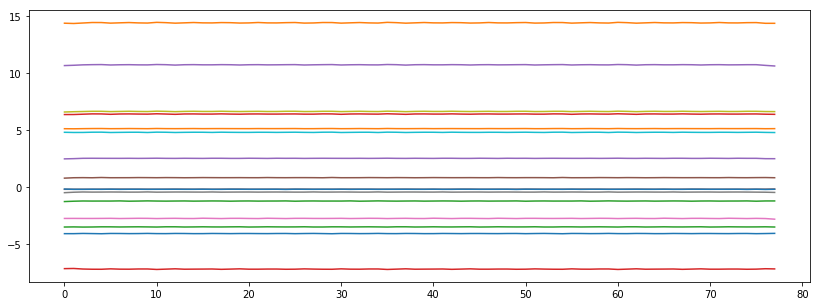

In [13]:
plt.figure(figsize = (14, 5))
for i in range(emb.shape[1]):
    plt.plot(emb.T[i])

In [29]:
import librosa
import librosa.display
import IPython.display as ipd


In [22]:
x, sr = librosa.core.load('/home/julia/DeepVoice_project/LibriSpeech_small/train-clean-100/19/198/19-198-0002.wav')

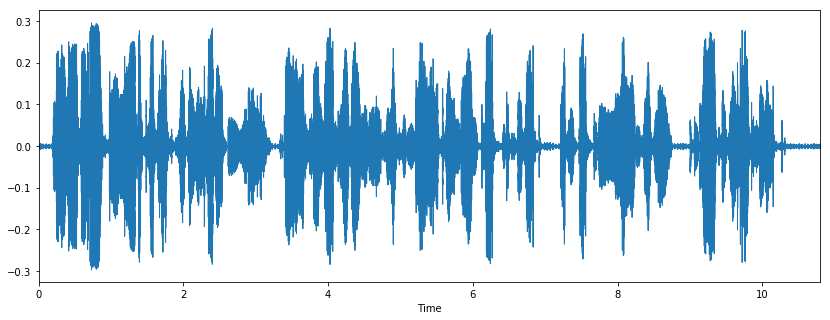

In [27]:
plt.figure(figsize = (14, 5))
librosa.display.waveplot(x, sr=sr)

In [31]:
ipd.Audio(x, rate = sr)

In [80]:
np.concatenate([[1, 2], [3, 4]])

array([1, 2, 3, 4])

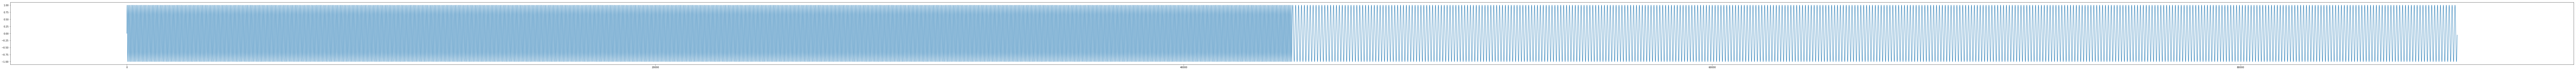

In [90]:
# Let's synthesize a pure tone at 440 Hz:
sr = 22050 # sample rate
T = 4.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
# x = 0.5*np.sin(2*np.pi*440*t)                # pure sine wave at 440 Hz
# x =  0.4*np.sin(2*np.pi*440*t) + 0.6*np.sin(2*np.pi*200*(t))             # pure sine wave at 440 Hz
x = np.concatenate([np.sin(2*np.pi*440*t)[:int(T*sr/2)], np.sin(2*np.pi*200*(t))[int(T*sr/2):]])

ipd.Audio(x, rate = sr)

In [91]:
librosa.output.write_wav('/home/julia/DeepVoice_data/samples/tone_440-200.wav', x, sr)
